# DP4: Control of a Drone

Import all modules used in code

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import secrets
import ae353_drone
import scipy
from scipy import linalg
from scipy import signal
import sympy as sym

Produce random number to use as seed for simulator (to reproduce results)

In [2]:
seed = secrets.randbits(32)
print(seed)

1628996061


Initialize simulator with the chosen seed

In [3]:
seed1 = 1278929124

simulator = ae353_drone.Simulator(
    display=False,
    seed=seed1,
)

# ================== Dynamic model derivation ==================

Define physical parameters of the model, these values do not change

In [4]:
params = {
    'm': 0.5,
    'Jx': 0.0023,
    'Jy': 0.0023,
    'Jz': 0.0040,
    'l': 0.175,
    'g': 9.81,
}

Derive equations of motion as per the code provided by Professor Bretl

In [5]:
# components of position (meters)
p_x, p_y, p_z = sym.symbols('p_x, p_y, p_z')

# yaw, pitch, roll angles (radians)
psi, theta, phi = sym.symbols('psi, theta, phi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')
v_in_body = sym.Matrix([v_x, v_y, v_z])

# components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')
w_in_body = sym.Matrix([w_x, w_y, w_z])

# components of net rotor torque
tau_x, tau_y, tau_z = sym.symbols('tau_x, tau_y, tau_z')

# net rotor force
f_z = sym.symbols('f_z')

# parameters
m = sym.nsimplify(params['m'])
Jx = sym.nsimplify(params['Jx'])
Jy = sym.nsimplify(params['Jy'])
Jz = sym.nsimplify(params['Jz'])
l = sym.nsimplify(params['l'])
g = sym.nsimplify(params['g'])
J = sym.diag(Jx, Jy, Jz)

# rotation matrices
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])
R_body_in_world = Rz @ Ry @ Rx

# angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# applied forces
f_in_body = R_body_in_world.T @ sym.Matrix([[0], [0], [-m * g]]) + sym.Matrix([[0], [0], [f_z]])

# applied torques
tau_in_body = sym.Matrix([[tau_x], [tau_y], [tau_z]])

# equations of motion
f = sym.Matrix.vstack(
    R_body_in_world * v_in_body,
    M * w_in_body,
    (1 / m) * (f_in_body - w_in_body.cross(m * v_in_body)),
    J.inv() * (tau_in_body - w_in_body.cross(J * w_in_body)),
)

f = sym.simplify(f, full=True)
print('The equations of motion are:')
f

The equations of motion are:


Matrix([
[v_x*cos(psi)*cos(theta) + v_y*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)) + v_z*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))],
[v_x*sin(psi)*cos(theta) + v_y*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)) - v_z*(sin(phi)*cos(psi) - sin(psi)*sin(theta)*cos(phi))],
[                                                                      -v_x*sin(theta) + v_y*sin(phi)*cos(theta) + v_z*cos(phi)*cos(theta)],
[                                                                                                 (w_y*sin(phi) + w_z*cos(phi))/cos(theta)],
[                                                                                                              w_y*cos(phi) - w_z*sin(phi)],
[                                                                                  w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)],
[                                                                                                   v_y*w_z - v_z*w_y + 981*sin(theta)/100],
[   

### Linearize dynamic model

Find and check equilibirum point

In [6]:
# Ignore scientific notation for small numbers
np.set_printoptions(suppress=True)

#create lambda function to find equilibrium point
f_num = sym.lambdify([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z], f)

#define equilibrium values
p_xe = 0.0
p_ye = 0.0
p_ze = 0.0
psie = 0.0
thetae = 0.0
phie = 0.0
v_xe = 0.0
v_ye = 0.0
v_ze = 0.0
w_xe = 0.0
w_ye = 0.0
w_ze = 0.0
tau_xe = 0.0
tau_ye = 0.0
tau_ze = 0.0
f_ze = 9.81/2   # f_ze is not zero since the drone must counteract gravity!


#check if equilibirum is satisfied
check = f_num(p_xe, p_ye, p_ze, psie, thetae, phie, v_xe, v_ye, v_ze, w_xe, w_ye, w_ze, tau_xe, tau_ye, tau_ze, f_ze)
if np.all((check == 0)):
    print('Equilibirum is satisfied')
else:
    print('Check your equilibrium point')

Equilibirum is satisfied


Find A and B matrices

In [7]:
#----------------Find A----------------#
#create lamba function for jacobians
A_num = sym.lambdify([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z], 
                     f.jacobian([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z]))

#evaluate at equilibrium point
A = A_num(p_xe, p_ye, p_ze, psie, thetae, phie, v_xe, v_ye, v_ze, w_xe, w_ye, w_ze, tau_xe, tau_ye, 
          tau_ze, f_ze).astype(float)

#----------------Find B----------------#
#create lamba function for jacobians
B_num = sym.lambdify([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z], 
                     f.jacobian([tau_x, tau_y, tau_z, f_z]))

#evaluate at equilibrium point
B = B_num(p_xe, p_ye, p_ze, psie, thetae, phie, v_xe, v_ye, v_ze, w_xe, w_ye, w_ze, tau_xe, tau_ye, 
          tau_ze, f_ze).astype(float)


#print results
print('Your A matrix is:')
print(A, '\n')
print('Your B matrix is:')
print(B)

Your A matrix is:
[[ 0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.   -0.    0.   -0.    0.    1.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.  ]
 [ 0.    0.    0.    0.    0.   -0.    0.    0.    0.    0.    1.   -0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.  ]
 [ 0.    0.    0.    0.    9.81  0.    0.    0.   -0.    0.   -0.    0.  ]
 [ 0.    0.    0.    0.    0.   -9.81 -0.    0.    0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.   -0.    0.   -0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   -0.   -0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]] 

Your B matrix is:
[[  0.          0.          0.          0.       ]
 [  0.    

### Check for controllability

In [8]:
# Create index variable for loop
n = A.shape[0]

# Initialize W with its first column, where W is the controllability matrix
W = B

# Create W one column at a time by iterating over i from 1 to n-1
for i in range(1, n):
    col = np.linalg.matrix_power(A, i) @ B
    W = np.block([W, col])

# Check if controllable system, the rank must match the shape of A
print('The shape of A is')
print(A.shape , '\n')
print('The rank of W_c is')
print(np.linalg.matrix_rank(W), '\n')

if A.shape[0] == np.linalg.matrix_rank(W):
    print('The system is controllable')
else:
    print('The system is not controllable')

The shape of A is
(12, 12) 

The rank of W_c is
12 

The system is controllable


# ================== Sensor model definition ==================

Define the sensor model, as provided by Professor Bretl

In [9]:
g = sym.Matrix([p_x, p_y, p_z, psi])
#print g to visualize result
g

Matrix([
[p_x],
[p_y],
[p_z],
[psi]])

### Linearize sensor model

Find and check equilibrium point

In [10]:
#create lambda function to find equilibrium point
f_num = sym.lambdify([p_x, p_y, p_z, psi], g)

#define equilibrium values
p_xe = 0.0
p_ye = 0.0
p_ze = 0.0
psie = 0.0

#check if equilibirum is satisfied
check = f_num(p_xe, p_ye, p_ze, psie)
if np.all((check == 0)):
    print('Equilibirum is satisfied')
else:
    print('Check your equilibrium point')

Equilibirum is satisfied


Find C and D matrices

In [11]:
#----------------Find C----------------#
#create lamba function for jacobians
C_num = sym.lambdify([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z], 
                     g.jacobian([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z]))
#evaluate at equilibrium point
C = C_num(p_xe, p_ye, p_ze, psie, thetae, phie, v_xe, v_ye, v_ze, w_xe, w_ye, w_ze, tau_xe, tau_ye, 
          tau_ze, f_ze).astype(float)


#----------------Find D----------------#
#create lamba function for jacobians
D_num = sym.lambdify([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z], 
                     g.jacobian([tau_x, tau_y, tau_z, f_z]))
#evaluate at equilibrium point
D = D_num(p_xe, p_ye, p_ze, psie, thetae, phie, v_xe, v_ye, v_ze, w_xe, w_ye, w_ze, tau_xe, tau_ye, 
          tau_ze, f_ze).astype(float)


#print results
print('Your C matrix is:')
print(C, '\n')
print('Your D matrix is:')
print(D)                      #D will be a zero matrix as mentioned in the report, 
                              #and is not necessary to produce our controller/observer

Your C matrix is:
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]] 

Your D matrix is:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


### Check for Observability

In [12]:
# Initialize W with its first column, where W is the observability matrix
W = C

# Create W one row at a time by iterating over i from 1 to n-1
for i in range(1, n):
    col = C @ np.linalg.matrix_power(A, i)
    W = np.block([[W], 
                  [col]])

# Check if observable system, the rank must match the shape of A
print('The shape of A is')
print(A.shape , '\n')
print('The rank of W_o is')
print(np.linalg.matrix_rank(W.T), '\n')

if A.shape[0] == np.linalg.matrix_rank(W.T):
    print('The system is observable')
else:
    print('The system is not observable')

The shape of A is
(12, 12) 

The rank of W_o is
12 

The system is observable


# =========== Controller and observer design: LQR ===========

Define a function to return the solution to the LQR problem:

In [13]:
def lqr(A, B ,Q, R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @ B.T @ P
    return K

### Find gain matrix K
Define weights:

In [14]:
# Define Qc
Qc = np.diag([9., 9., 18., 1., 0.9, 0.9, 1.1, 1.1, 1.1, 2., 2., 2.])

# Define Rc
Rc = 10*np.diag([1., 1., 1., 1.])

Find gain matrix K

In [15]:
#Using LQR solver
K = lqr(A, B, Qc, Rc)
print('Your K matrix is:')
print(K)

Your K matrix is:
[[-0.         -0.9486833  -0.          0.          0.          2.68744805
   0.         -0.79358887 -0.          0.4608278  -0.          0.        ]
 [ 0.9486833  -0.          0.         -0.          2.68744805 -0.
   0.79358887  0.         -0.         -0.          0.4608278  -0.        ]
 [-0.          0.          0.          0.31622777 -0.         -0.
  -0.          0.          0.          0.         -0.          0.45003313]
 [ 0.         -0.          1.34164079  0.         -0.         -0.
  -0.          0.          1.20484056 -0.         -0.          0.        ]]


### Find gain matrix L
Define weights:

In [16]:
# Define Ro
Ro = np.diag([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

#Define Qo
Qo = 2.5*linalg.inv(np.diag([1., 1., 1., 1.]))

Find gain matrix L

In [17]:
# Using LQR solver making the appropriate replacements
L = lqr(A.T, C.T, linalg.inv(Ro), linalg.inv(Qo)).T
print('Your L matrix is:')
print(L)

Your L matrix is:
[[ 6.19074455  0.          0.          0.        ]
 [ 0.          6.19074455  0.          0.        ]
 [ 0.          0.          2.37955409  0.        ]
 [ 0.          0.          0.          2.37955409]
 [ 2.87648914  0.          0.          0.        ]
 [ 0.         -2.87648914  0.          0.        ]
 [17.91265902  0.          0.          0.        ]
 [ 0.         17.91265902  0.          0.        ]
 [ 0.          0.          1.58113883  0.        ]
 [ 0.         -1.58113883  0.          0.        ]
 [ 1.58113883  0.          0.          0.        ]
 [ 0.          0.          0.          1.58113883]]


### Check for asymptotic stability

Use the separation principle, i.e. check if the controller and obersever closed loop systems are asymptotically stable on their own. If they are, the whole system is asymptotically stable!

In [18]:
#check eigenvalues to ensure asymptotic stabilty of controller
F = A - B@K
#find eigenvalues
s = linalg.eigvals(F)
print('\n The eigenvalues of your controller are:\n')
print(s)

if (s.real < 0).all() == True:
    print('\n The eigenvalues of your controller are all of negative real part, \
    \n therefore the closed-loop system is indeed asymptotically stable')
else:
    print('\n The eigenvalues of your controller are NOT all of negative real part, please refine your Q and R weights')
    
#check eigenvalues to ensure asymptotic stabilty of observer
F = A - L@C
#find eigenvalues
s = linalg.eigvals(F)
print('\n The eigenvalues of your observer are:\n')
print(s)

if (s.real < 0).all() == True:
    print('\n The eigenvalues of your observer are all of negative real part, \
    \n therefore the closed-loop observer is indeed asymptotically stable')
else:
    print('\n The eigenvalues of your observer are NOT all of negative real part, please refine your Q and R weights')


 The eigenvalues of your controller are:

[-194.43954011+0.j         -194.43954011+0.j
 -111.8011627 +0.j           -1.79598031+2.38997786j
   -1.79598031-2.38997786j   -1.79598031+2.38997786j
   -1.79598031-2.38997786j   -2.32841222+0.j
   -2.32841222+0.j           -0.70712092+0.j
   -1.20484056+1.10979313j   -1.20484056-1.10979313j]

 The eigenvalues of your controller are all of negative real part,     
 therefore the closed-loop system is indeed asymptotically stable

 The eigenvalues of your observer are:

[-1.30070672+2.07143425j -1.30070672-2.07143425j -1.30070672+2.07143425j
 -1.30070672-2.07143425j -2.587242  +0.j         -2.587242  +0.j
 -1.18977704+0.40690222j -1.18977704-0.40690222j -1.00208912+0.j
 -1.00208912-0.j         -1.18977704+0.40690222j -1.18977704-0.40690222j]

 The eigenvalues of your observer are all of negative real part,     
 therefore the closed-loop observer is indeed asymptotically stable


# =========== Define controllers ===========

Our drone, Vector:

In [19]:
class Controller:
    def __init__(self):
        
        #pass in variables from before
        self.dt = 0.01
        self.A = A
        self.B = B
        self.C = C
        self.K = K
        self.L = L
        self.p_xe = p_xe
        self.p_ye = p_ye
        self.p_ze = p_ze
        self.psie = psie
        self.thetae = thetae
        self.phie = phie
        self.v_xe = v_xe
        self.v_ye = v_ye
        self.v_ze = v_ze
        self.w_xe = w_xe
        self.w_ye = w_ye
        self.w_ze = w_ze
        self.tau_xe = tau_xe
        self.tau_ye = tau_ye
        self.tau_ze = tau_ze
        self.f_ze = f_ze
        
        
        #keep track of state estimate and desired state
        self.variables_to_log = ['xhat', 'xdes']
        
    def get_color(self):
        return [0., 1., 0.]

    def reset(
            self,
            p_x_meas, p_y_meas, p_z_meas, # <-- measured position of drone (meters)
            yaw_meas,                     # <-- measured yaw angle of drone (radians)
        ):
        
        #initialize state estimate
        self.xhat = np.array([p_x_meas, p_y_meas, p_z_meas, yaw_meas, 0., 0., 0., 0., 0., 0., 0., 0.])
        self.xdes = np.array([])

    def run(
            self,
            p_x_meas, p_y_meas, p_z_meas, # <-- measured position of drone (meters)
            yaw_meas,                     # <-- measured yaw angle of drone (radians)
            p_x_ring, p_y_ring, p_z_ring, # <-- center position of next ring (meters)
            is_last_ring,                 # <-- True if next ring is the last ring, False otherwise
            pos_others,                   # <-- 2d array of size n x 3, where n is the number
                                          #     of all *other* drones - the ith row in this array
                                          #     has the coordinates [x_i, y_i, z_i], in meters, of
                                          #     the ith other drone
        ):
        
        
        #define new input
        udes = np.array([0.0, 0.0, 0.0, 0.0])
        
        #define new state
        self.xdes = np.array([p_x_ring, p_y_ring, p_z_ring, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
        
        #implement tracking
        if is_last_ring == False: #<-----------------------------------if its not the last ring
            P_hat = self.xhat[0:3] #<----------------------------------find current position
            P_ring = np.array([p_x_ring, p_y_ring, p_z_ring]) #<-------find position of ring
            r = 1.20 #<------------------------------------------------define step magnitude
        
            if np.linalg.norm(P_ring-P_hat) > r: #<----------------------------------if distance to ring is greater than r
                pdes = P_hat + r*((P_ring-P_hat)/np.linalg.norm(P_ring-P_hat)) #<----create new desired position
                self.xdes[0:3]=pdes #<-----------------------------------------------update desired state with pdes
                
        else: #<-----------------------------------------------------------------if its last ring
            P_hat = self.xhat[0:3] #<--------------------------------------------find current position
            P_ring = np.array([p_x_ring, p_y_ring, p_z_ring]) #<-----------------find position of ring
            r = 1.7 #<-----------------------------------------------------------define new step magnitude
            pdes = P_hat + r*((P_ring-P_hat)/np.linalg.norm(P_ring-P_hat)) #<----create new desired position
            self.xdes[0:3]=pdes #<-----------------------------------------------update desired state with pdes
        
        #implement controller
        u = udes -self.K @ (self.xhat - self.xdes)
        
        #implement observer
        y = np.array([p_x_meas, p_y_meas, p_z_meas, yaw_meas]) - np.array([self.p_xe, self.p_ye, self.p_ze, self.psie])
        
        #update state estimate
        self.xhat += self.dt * (self.A@self.xhat + self.B@u - L@(self.C@self.xhat - y))
        
        #extract actuator commands
        tau_x = u[0] + self.tau_xe
        tau_y = u[1] + self.tau_ye
        tau_z = u[2] + self.tau_ze
        f_z = u[3] + self.f_ze

        return tau_x, tau_y, tau_z, f_z

Copy of first controller, aka darth Vector: This controller is used to test multiple drones at once

In [20]:
class Controller2:
    def __init__(self):
        
        #pass in variables from before
        self.dt = 0.01
        self.A = A
        self.B = B
        self.C = C
        self.K = K
        self.L = L
        self.p_xe = p_xe
        self.p_ye = p_ye
        self.p_ze = p_ze
        self.psie = psie
        self.thetae = thetae
        self.phie = phie
        self.v_xe = v_xe
        self.v_ye = v_ye
        self.v_ze = v_ze
        self.w_xe = w_xe
        self.w_ye = w_ye
        self.w_ze = w_ze
        self.tau_xe = tau_xe
        self.tau_ye = tau_ye
        self.tau_ze = tau_ze
        self.f_ze = f_ze
        
        
        #keep track of state estimate and desired state
        self.variables_to_log = ['xhat', 'xdes']
        
    def get_color(self):
        return [0., 1., 0.]

    def reset(
            self,
            p_x_meas, p_y_meas, p_z_meas, # <-- measured position of drone (meters)
            yaw_meas,                     # <-- measured yaw angle of drone (radians)
        ):
        
        #initialize state estimate
        self.xhat = np.array([p_x_meas, p_y_meas, p_z_meas, yaw_meas, 0., 0., 0., 0., 0., 0., 0., 0.])
        self.xdes = np.array([])

    def run(
            self,
            p_x_meas, p_y_meas, p_z_meas, # <-- measured position of drone (meters)
            yaw_meas,                     # <-- measured yaw angle of drone (radians)
            p_x_ring, p_y_ring, p_z_ring, # <-- center position of next ring (meters)
            is_last_ring,                 # <-- True if next ring is the last ring, False otherwise
            pos_others,                   # <-- 2d array of size n x 3, where n is the number
                                          #     of all *other* drones - the ith row in this array
                                          #     has the coordinates [x_i, y_i, z_i], in meters, of
                                          #     the ith other drone
        ):
        
        
        #define new input
        udes = np.array([0.0, 0.0, 0.0, 0.0])
        
        #define new state
        self.xdes = np.array([p_x_ring, p_y_ring, p_z_ring, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
        
        #implement tracking
        if is_last_ring == False: #<-----------------------------------if its not the last ring
            P_hat = self.xhat[0:3] #<----------------------------------find current position
            P_ring = np.array([p_x_ring, p_y_ring, p_z_ring]) #<-------find position of ring
            r = 1.20 #<------------------------------------------------define step magnitude
        
            if np.linalg.norm(P_ring-P_hat) > r: #<----------------------------------if distance to ring is greater than r
                pdes = P_hat + r*((P_ring-P_hat)/np.linalg.norm(P_ring-P_hat)) #<----create new desired position
                self.xdes[0:3]=pdes #<-----------------------------------------------update desired state with pdes
                
        else: #<-----------------------------------------------------------------if its last ring
            P_hat = self.xhat[0:3] #<--------------------------------------------find current position
            P_ring = np.array([p_x_ring, p_y_ring, p_z_ring]) #<-----------------find position of ring
            r = 1.7 #<-----------------------------------------------------------define new step magnitude
            pdes = P_hat + r*((P_ring-P_hat)/np.linalg.norm(P_ring-P_hat)) #<----create new desired position
            self.xdes[0:3]=pdes #<-----------------------------------------------update desired state with pdes
        
        #implement controller
        u = udes -self.K @ (self.xhat - self.xdes)
        
        #compute output
        y = np.array([p_x_meas, p_y_meas, p_z_meas, yaw_meas]) - np.array([self.p_xe, self.p_ye, self.p_ze, self.psie])
        
        #implement observer by updating state estimate
        self.xhat += self.dt * (self.A@self.xhat + self.B@u - L@(self.C@self.xhat - y))
        
        #extract actuator commands
        tau_x = u[0] + self.tau_xe
        tau_y = u[1] + self.tau_ye
        tau_z = u[2] + self.tau_ze
        f_z = u[3] + self.f_ze

        return tau_x, tau_y, tau_z, f_z

Allow long runtimes and print statements in controller code

In [21]:
simulator.set_rules(
    error_on_print=False,    
    error_on_timeout=False,  
)

# ======== Test the drone in simulation by itself ========

In [22]:
#----------Inititalize arrays to store data----------#
#times until completion
t = np.array([])

#counters
finished = 0
collision = 0
tooslow = 0
ring = np.array([0., 0., 0., 0., 0., 0., 0.])

#error between estimated position and actual position
err_x_obs = np.array([])
err_y_obs = np.array([])
err_z_obs = np.array([])

#error between actual position and desired position
err_x_cont = np.array([])
err_y_cont = np.array([])
err_z_cont = np.array([])

#run times of controller
run_time = np.array([])

#----------Loop through x simulations----------#
x = 200
for i in range(x):
    
    #------Get simulator ready------#
    #clear drones to restart simulation
    simulator.clear_drones()
    #add vector to the race (and prepare to steal da moon)
    simulator.add_drone(Controller, '651725086', 'Vector.png')
    #reset the drone at random location in start ring
    simulator.reset()
    #run for 40.0 seconds to ensure drone has enough time to complete race
    simulator.run(max_time=40.0)
    
    #------Get raw data------#
    data = simulator.get_data('651725086')
    
    #----Find error between estimated position and actual position----#
    #assemble error for this one simularion
    err_x_temp = data['xhat'][:, 0] - data['p_x']
    err_y_temp = data['xhat'][:, 1] - data['p_y']
    err_z_temp = data['xhat'][:, 2] - data['p_z']
    #append error to respective arrays
    err_x_obs = np.append(err_x_obs, err_x_temp)
    err_y_obs = np.append(err_y_obs, err_y_temp)
    err_z_obs = np.append(err_z_obs, err_z_temp)
    
    #----Find error between actual position and desired position----#
    #assemble error for this one simularion
    err_x_temp = data['p_x'] - data['xdes'][:, 0]
    err_y_temp = data['p_y'] - data['xdes'][:, 1]
    err_z_temp = data['p_z'] - data['xdes'][:, 2]
    
    # Estimated position 
    #append error to respective arrays
    err_x_cont = np.append(err_x_cont, err_x_temp)
    err_y_cont = np.append(err_y_cont, err_y_temp)
    err_z_cont = np.append(err_z_cont, err_z_temp)
    

    
    #----Check for failure and time until finish----#
    (
        fail,
        finish,
        time_finish,
    ) = simulator.get_result('651725086')
    
    
    if fail:                           #if it fails, controller run-time exceeded, add to too slow
        tooslow = tooslow + 1          
    elif finish:                       #if it finished, add to finish counter
        finished += 1
        t = np.append(t, time_finish)
    else:                              #if it doesn't finish, but doesn't fail, drone has collided
        if data['is_last_ring'][-1]==True:         # It has collided with the last ring
            ring[6]=ring[6] + 1
        else:
            if data['p_x'][-1]<0.5:   # It has collided with the starting ring
                ring[0] = ring[0] + 1
            elif data['p_x'][-1]<5.5:  # It has collided with the first ring
                ring[1] = ring[1] + 1
            elif data['p_x'][-1]<10.5: # It has collided with the second ring
                ring[2] = ring[2] + 1
            elif data['p_x'][-1]<15.5: # It has collided with the third ring
                ring[3] = ring[3] + 1
            elif data['p_x'][-1]<20.5: # It has collided with the fourth ring
                ring[4] = ring[4] + 1
            elif data['p_x'][-1]<25.5: # It has collided with the fifth ring
                ring[5] = ring[5] + 1
        collision = collision + 1                           
    
    #append run time to array
    run_time = np.append(run_time, data['run_time'])
    
  

# ======== Evaluate control design ========

Check how many finished, how many failed

In [23]:
print(collision, 'drones hit a ring and could not finish')
print('      ', ring[0], 'collided with starting ring')
print('      ', ring[1],'collided with the first ring')
print('      ', ring[2], 'collided with the second ring')
print('      ', ring[3], 'collided with the third ring')
print('      ', ring[4], 'collided with the fourth ring')
print('      ', ring[5], 'collided with the fifth ring')
print('      ', ring[6], 'collided with the last ring')
print(tooslow, 'drones exceeded computation time')
print(finished, 'were able to finish')

2 drones hit a ring and could not finish
       0.0 collided with starting ring
       1.0 collided with the first ring
       0.0 collided with the second ring
       0.0 collided with the third ring
       1.0 collided with the fourth ring
       0.0 collided with the fifth ring
       0.0 collided with the last ring
0 drones exceeded computation time
198 were able to finish


### How fast the drone completes the race

Plot histrogram of finish times to see if the average time of completion meets the requirement. If it does, the control design is working well!

Average time to completion:  22.201010101010098
Percentage of the time that the drone finishes the race:  99.0 %


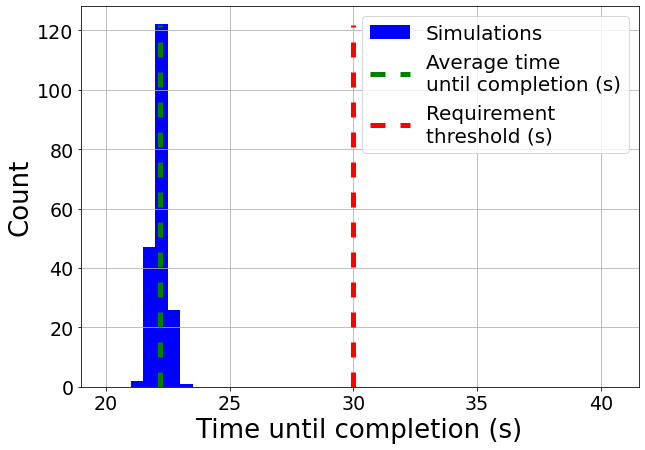

In [24]:
#Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(t, bins = np.arange(20,41, 0.5), color = 'b',label = 'Simulations')
ax.set_xlabel("Time until completion (s)", fontsize=26)
ax.set_ylabel("Count", fontsize=26)
ax.tick_params(labelsize=19)

# Find average time until completion
mean = np.mean(t)
print("Average time to completion: ", mean)

#print % of race completion
percent = finished / x *100
print("Percentage of the time that the drone finishes the race: ", percent, "%")

# Plot average time to finish
ax.axvline(x = mean, ymin = 0, ymax = .95, linestyle = (0,(3,3)), color = 'g', linewidth = 5, label = 'Average time\nuntil completion (s)')

# Plot requirement of 30 seconds
ax.axvline(x = 30, ymin = 0, ymax = 0.95, color = 'r', linestyle = (0,(3,3)), linewidth = 5, label = 'Requirement\nthreshold (s)' % mean)

#legend and grid to make it pretty
ax.legend(loc='best', fontsize = 20)
ax.grid()

#force consistent figure size
plt.rcParams.update({'figure.autolayout': True})
fig.savefig('Time_Until_Completion.png', facecolor='white', transparent=False)

# Show plot
plt.show()

### How well the controller is working

Plot error between actual position and desired position to check how well the controller is working

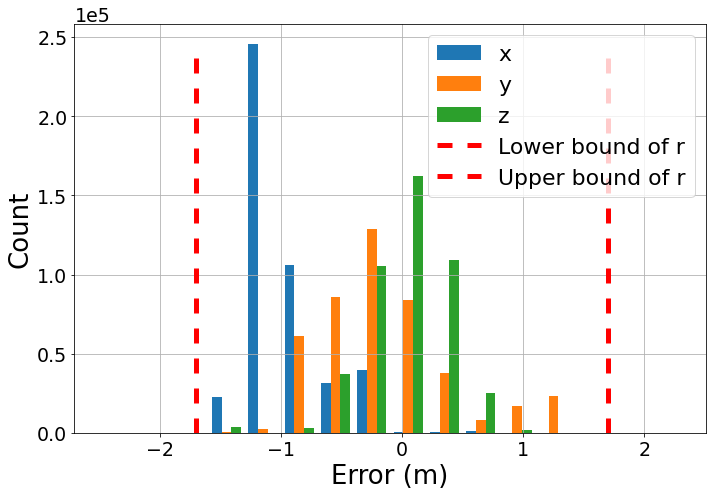

In [25]:
#Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist([err_x_cont, err_y_cont, err_z_cont], bins = np.arange(-2.5, 2.5, .3),label = ['x', 'y', 'z'])
ax.set_xlabel("Error (m)", fontsize=26)
ax.set_ylabel("Count", fontsize=26)
ax.tick_params(labelsize=19)
ax.ticklabel_format(style='scientific', scilimits=(0, 0), axis='y')
ax.yaxis.offsetText.set_fontsize(19)

#Plot upper bound of step r
ax.axvline(x = -1.7, ymin = 0, ymax = .95, linestyle = (0,(3,3)), color = 'r', linewidth = 5, label = 'Lower bound of r')

#Plot lower bound of step r
ax.axvline(x = 1.7, ymin = 0, ymax = 0.95, color = 'r', linestyle = (0,(3,3)), linewidth = 5, label = 'Upper bound of r')

#legend and grid to make it pretty
ax.legend(loc='best', fontsize = 22)
ax.grid()

#force consistent figure size
plt.rcParams.update({'figure.autolayout': True})
fig.savefig('Controller.png', facecolor='white', transparent=False)

# Show plot
plt.show()

### How well the observer is working

Plot error between estimated and actual postion to check how well the oberserver is working

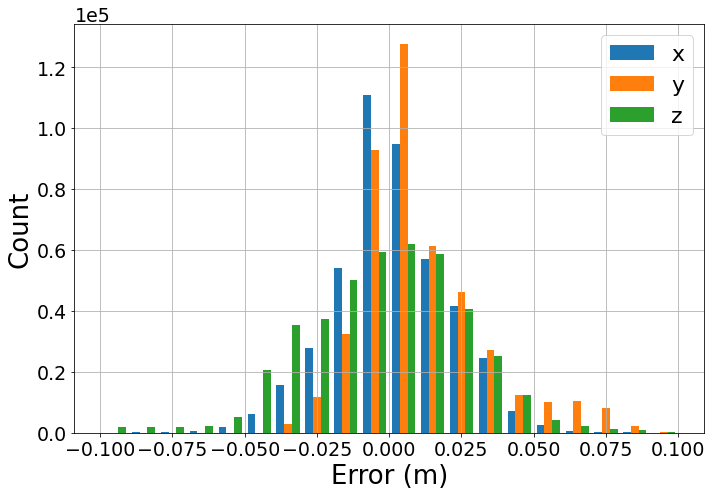

In [26]:
# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist([err_x_obs, err_y_obs, err_z_obs], bins = np.arange(-.1, .1001, 0.01),label = ['x', 'y', 'z'])
ax.set_xlabel("Error (m)", fontsize=26)
ax.set_ylabel("Count", fontsize=26)
ax.tick_params(labelsize=19)
ax.ticklabel_format(style='scientific', scilimits=(0, 0), axis='y')
ax.yaxis.offsetText.set_fontsize(19)

#legend and grid to make it pretty
ax.legend(loc='best', fontsize = 22)
ax.grid()

#force consistent figure size
plt.rcParams.update({'figure.autolayout': True})
fig.savefig('Observer.png', facecolor='white', transparent=False)

# Show plot
plt.show()

### How long it takes the controller to run

Plot computation time to ensure the controller runs fast enough to avoid disqualification in the race.

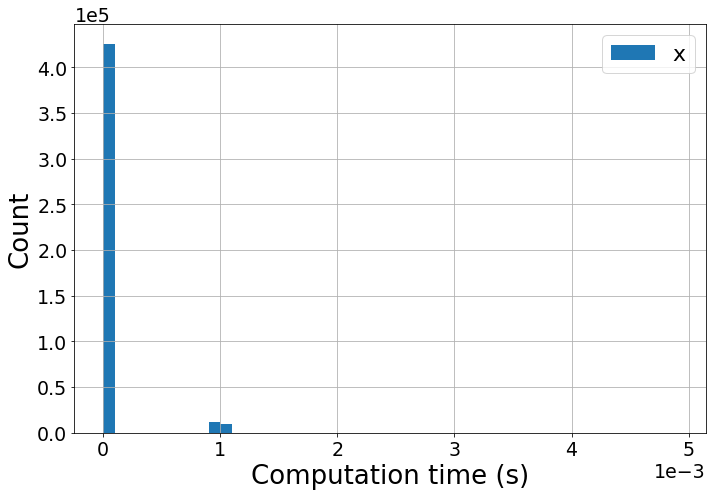

In [27]:
#Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(run_time, bins = np.arange(0, 0.005, .0001), label = ['x', 'y', 'z'])
ax.set_xlabel("Computation time (s)", fontsize=26)
ax.set_ylabel("Count", fontsize=26)
ax.tick_params(labelsize=19)
ax.ticklabel_format(style='scientific', scilimits=(0, 0))
ax.yaxis.offsetText.set_fontsize(19)
ax.xaxis.offsetText.set_fontsize(19)

#legend and grid to make it pretty
ax.legend(loc='best', fontsize = 22)
ax.grid()

#force consistent figure size
plt.rcParams.update({'figure.autolayout': True})
fig.savefig('Computation.png', facecolor='white', transparent=False)

# Show plot
plt.show()

# ======== Run two drones at once ========

In [28]:
#----------Inititalize arrays to store data----------#
#times until completion
t = np.array([])

#counter to mark how many finish the race
finished = 0
collision_drone = 0
collision_ring = 0
tooslow = 0
ring = np.array([0., 0., 0., 0., 0., 0., 0.])

#error between estimated position and actual position
err_x_obs = np.array([])
err_y_obs = np.array([])
err_z_obs = np.array([])

#error between actual position and desired position
err_x_cont = np.array([])
err_y_cont = np.array([])
err_z_cont = np.array([])

#run times of controller
run_time = np.array([])


#----------Loop through x simulations----------#
x = 200
for i in range(x):
    
    #------Get simulator ready------#
    #clear drones to restart simulation
    simulator.clear_drones()
    #add vector and darth vector to the race (and prepare to steal da moon)
    simulator.add_drone(Controller, '651725086', 'Vector.png')
    simulator.add_drone(Controller2, '651725087', 'Vector.png')
    #reset the drone at random location in start ring
    simulator.reset()
    #run for 40.0 seconds to ensure drone has enough time to complete race
    simulator.run(max_time=40.0)
    
    #------Get raw data------#
    data = simulator.get_data('651725086')  # Vector's data, what we are analysing
    data2 = simulator.get_data('651725087') # Darth Vector's data
    
    #----Find error between estimated position and actual position----#
    #assemble error for this one simularion
    err_x_temp = data['xhat'][:, 0] - data['p_x']
    err_y_temp = data['xhat'][:, 1] - data['p_y']
    err_z_temp = data['xhat'][:, 2] - data['p_z']
    #append error to respective arrays
    err_x_obs = np.append(err_x_obs, err_x_temp)
    err_y_obs = np.append(err_y_obs, err_y_temp)
    err_z_obs = np.append(err_z_obs, err_z_temp)
    
    #----Find error between actual position and desired position----#
    #assemble error for this one simularion
    err_x_temp = data['p_x'] - data['xdes'][:, 0]
    err_y_temp = data['p_y'] - data['xdes'][:, 1]
    err_z_temp = data['p_z'] - data['xdes'][:, 2]
    #append error to respective arrays
    err_x_cont = np.append(err_x_cont, err_x_temp)
    err_y_cont = np.append(err_y_cont, err_y_temp)
    err_z_cont = np.append(err_z_cont, err_z_temp)

    
    #----Check for failure and time until finish----#
    (
        fail,
        finish,
        time_finish,
    ) = simulator.get_result('651725086')
    
    (
        fail2,
        finish2,
        time_finish2,
    ) = simulator.get_result('651725087')
    
    
    if fail:                           #if it fails, controller run-time exceeded, add to too slow
        tooslow = tooslow + 1          
    elif finish:                       #if it finished, add to finish counter
        finished += 1
        t = np.append(t, time_finish)
    else:                              #if it doesn't finish, but doesn't fail, drone has collided
        if fail2==False and finish2==False: #If the drones collide with each other, 
                                            #both have failed to finish and not have fail
            collision_drone = collision_drone + 1
        else:
            if data['p_x'][-1]<0.5:    # It has collided with the starting ring
                ring[0] = ring[0] + 1
            elif data['p_x'][-1]<5.5:  # It has collided with the first ring
                ring[1] = ring[1] + 1
            elif data['p_x'][-1]<10.5: # It has collided with the second ring
                ring[2] = ring[2] + 1
            elif data['p_x'][-1]<15.5: # It has collided with the third ring
                ring[3] = ring[3] + 1
            elif data['p_x'][-1]<20.5: # It has collided with the fourth ring
                ring[4] = ring[4] + 1
            elif data['p_x'][-1]<25.5: # It has collided with the fifth ring
                ring[5] = ring[5] + 1
            elif data['p_x'][-1]<30.5: # It has collided with the last ring
                ring[6] = ring[6] + 1
            collision_ring = collision_ring + 1                         
    
    #append run time to array
    run_time = np.append(run_time, data['run_time'])

### How fast the drone completes the race

Plot histrogram of finish times to see if the average time of completion meets the requirement.

Average time to completion:  25.29207547169811
Percentage of the time that the drone finishes the race:  26.5 %


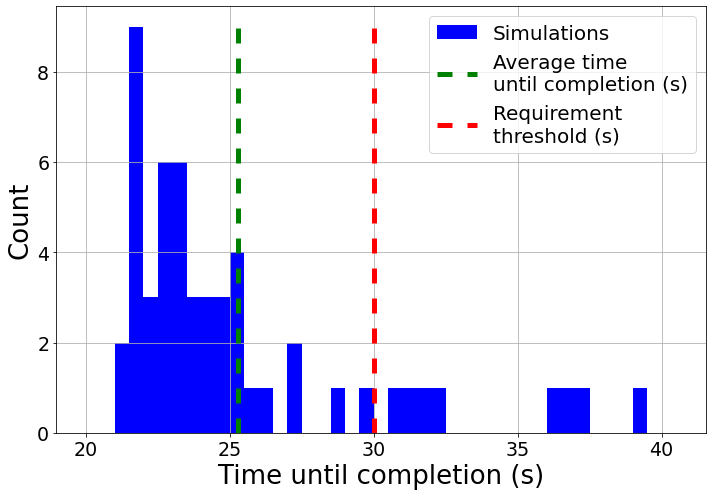

In [29]:
#Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(t, bins = np.arange(20,41, 0.5), color = 'b',label = 'Simulations')
ax.set_xlabel("Time until completion (s)", fontsize=26)
ax.set_ylabel("Count", fontsize=26)
ax.tick_params(labelsize=19)

# Find average time until completion
mean = np.mean(t)
print("Average time to completion: ", mean)

#print % of race completion
percent = finished / x *100
print("Percentage of the time that the drone finishes the race: ", percent, "%")

# Plot average time to finish
ax.axvline(x = mean, ymin = 0, ymax = .95, linestyle = (0,(3,3)), color = 'g', linewidth = 5, label = 'Average time\nuntil completion (s)')

# Plot requirement of 30 seconds
ax.axvline(x = 30, ymin = 0, ymax = 0.95, color = 'r', linestyle = (0,(3,3)), linewidth = 5, label = 'Requirement\nthreshold (s)' % mean)

#legend and grid to make it pretty
ax.legend(loc='best', fontsize = 20)
ax.grid()

#force consistent figure size
plt.rcParams.update({'figure.autolayout': True})
fig.savefig('Time_Until_Completion2.png', facecolor='white', transparent=False)

# Show plot
plt.show()  

Check how many finished, how many failed

In [30]:
print(collision_ring, 'drones hit a ring and could not finish')
print('      ', ring[0], 'collided with the first ring')
print('      ', ring[1], 'collided with the second ring')
print('      ', ring[2], 'collided with the third ring')
print('      ', ring[3], 'collided with the fourth ring')
print('      ', ring[4], 'collided with the fifth ring')
print('      ', ring[5], 'collided with the last ring')
print(collision_drone, 'drones collided with the other drone')
print(tooslow, 'drones exceeded computation time')
print(finished, 'were able to finish')

29 drones hit a ring and could not finish
       1.0 collided with the first ring
       3.0 collided with the second ring
       10.0 collided with the third ring
       6.0 collided with the fourth ring
       5.0 collided with the fifth ring
       3.0 collided with the last ring
118 drones collided with the other drone
0 drones exceeded computation time
53 were able to finish
